Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
24363/24363 ━━━━━━━━━━━━━━━━━━━━ 300s 12ms/step - loss: 0.0035 - val_loss: 9.5854e-04
Epoch 2/15
24363/24363 ━━━━━━━━━━━━━━━━━━━━ 320s 12ms/step - loss: 7.2389e-04 - val_loss: 2.0428e-04
Epoch 3/15
24363/24363 ━━━━━━━━━━━━━━━━━━━━ 334s 13ms/step - loss: 3.9572e-04 - val_loss: 1.1579e-04
Epoch 4/15
24363/24363 ━━━━━━━━━━━━━━━━━━━━ 316s 12ms/step - loss: 3.3234e-04 - val_loss: 7.7568e-05
Epoch 5/15
24363/24363 ━━━━━━━━━━━━━━━━━━━━ 299s 12ms/step - loss: 3.0707e-04 - val_loss: 5.9661e-05
Epoch 6/15
24363/24363 ━━━━━━━━━━━━━━━━━━━━ 300s 12ms/step - loss: 2.8867e-04 - val_loss: 5.4906e-05
Epoch 7/15
24363/24363 ━━━━━━━━━━━━━━━━━━━━ 317s 12ms/step - loss: 2.7836e-04 - val_loss: 5.8234e-05
Epoch 8/15
24363/24363 ━━━━━━━━━━━━━━━━━━━━ 307s 13ms/step - loss: 2.6813e-04 - val_loss: 4.6921e-05
Epoch 9/15
24363/24363 ━━━━━━━━━━━━━━━━━━━━ 323s 13ms/step - loss: 2.6547e-04 - val_loss: 5.9532e-05
Epoch 10/15
24363/24363 ━━━━━━━━━━━━━━━━━━━━ 315s 13ms/step - loss: 2.5869e-04 - val_loss: 7.14

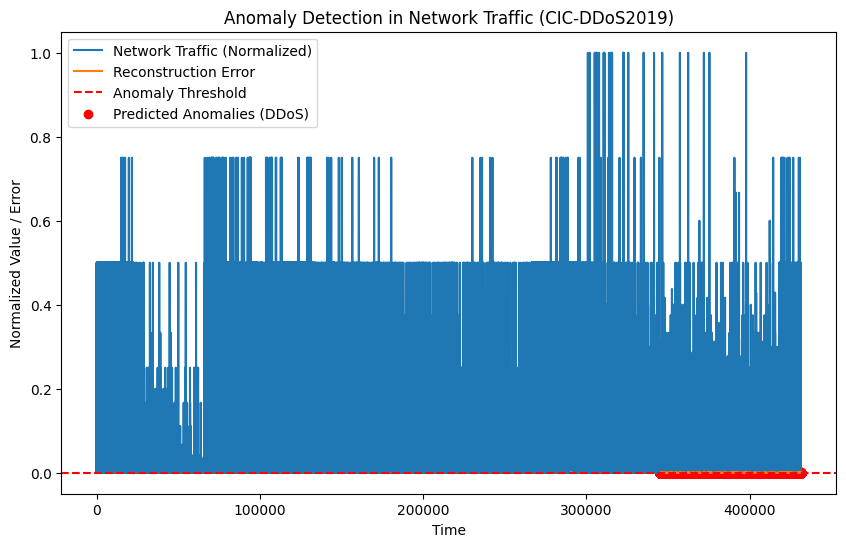

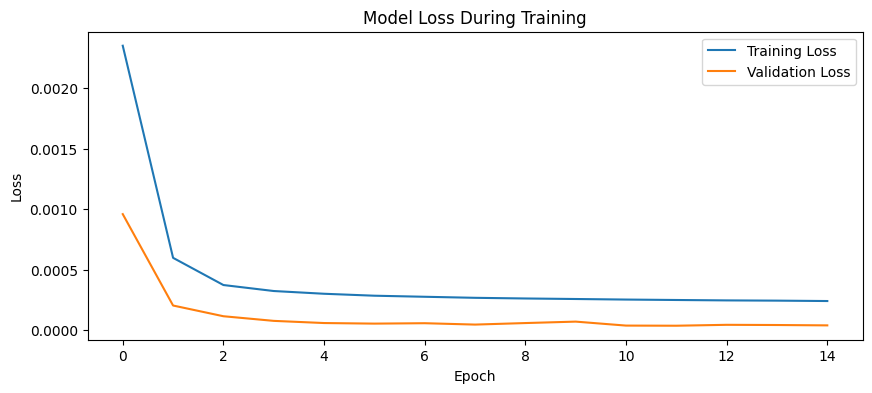

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import precision_score, recall_score, f1_score

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Load the CIC-DDoS2019 dataset
data_path = '/content/drive/MyDrive/CIC-DDoS2019 Dataset/cicddos2019_dataset.csv'
df = pd.read_csv(data_path)

# Select a relevant feature and labels
feature_column = 'Flow Packets/s'  # Feature for anomaly detection
label_column = 'Label'  # Use 'Label' for true anomaly labels
traffic_data = df[feature_column].fillna(0).values  # Replace NaN with 0
labels = df[label_column].values  # True labels (e.g., 'Benign' or attack types)

# Handle infinite values
traffic_data = np.where(np.isinf(traffic_data), 0, traffic_data)

# Prepare sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

seq_length = 10
scaler = MinMaxScaler()
traffic_scaled = scaler.fit_transform(traffic_data.reshape(-1, 1))
sequences = create_sequences(traffic_scaled, seq_length)

# Create corresponding label sequences (last value approach)
def create_label_sequences(labels, seq_length):
    label_sequences = []
    for i in range(len(labels) - seq_length):
        label_sequences.append(labels[i + seq_length - 1])
    return np.array(label_sequences)

label_sequences = create_label_sequences(labels, seq_length)

# Split into training and test sets
train_size = int(0.8 * len(sequences))
X_train = sequences[:train_size]
X_test = sequences[train_size:]
y_test = label_sequences[train_size:]  # True labels for test set

# Oversampling attack sequences
attack_indices = np.where(label_sequences[:train_size] != 'Benign')[0]
X_train_oversampled = np.vstack([X_train] + [X_train[attack_indices]] * 2)  # Duplicate attack sequences twice
y_train_oversampled = np.tile(label_sequences[:train_size], 3)  # Adjust labels accordingly

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train_oversampled.reshape((X_train_oversampled.shape[0], X_train_oversampled.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create LSTM Autoencoder model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(seq_length, 1), return_sequences=False),
    RepeatVector(seq_length),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, X_train, epochs=15, batch_size=32, validation_split=0.1, verbose=1)

# Predict and calculate reconstruction errors
predictions = model.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=(1, 2))

# Optimize threshold dynamically with lower range
thresholds = np.arange(np.mean(mse) - 0.5 * np.std(mse), np.mean(mse) + 3 * np.std(mse), 0.0001)
best_f1 = 0
for t in thresholds:
    pred = mse > t
    y_test_binary = (y_test != 'Benign').astype(int)
    f1 = f1_score(y_test_binary, pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t
threshold = best_threshold
anomalies_predicted = mse > threshold

# Check alignment
print("Longueur X_test:", len(X_test), "Longueur y_test_binary:", len(y_test_binary))

# Calculate and print metrics
print("Precision:", precision_score(y_test_binary, anomalies_predicted))
print("Recall:", recall_score(y_test_binary, anomalies_predicted))
print("F1-Score:", f1_score(y_test_binary, anomalies_predicted))

# Analyze predictions
print("True positives:", sum(anomalies_predicted & y_test_binary))
print("False positives:", sum(anomalies_predicted & ~y_test_binary))
print("False negatives:", sum(~anomalies_predicted & y_test_binary))
print("Moyenne MSE:", np.mean(mse), "Seuil:", threshold, "Max MSE:", np.max(mse))

# Visualize results without true labels
plt.figure(figsize=(10, 6))
plt.plot(traffic_scaled, label='Network Traffic (Normalized)')
plt.plot(np.arange(len(traffic_scaled) - len(mse), len(traffic_scaled)), mse, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.scatter(np.where(anomalies_predicted)[0] + len(traffic_scaled) - len(mse), mse[anomalies_predicted], color='red', label='Predicted Anomalies (DDoS)')
plt.legend()
plt.title('Anomaly Detection in Network Traffic (CIC-DDoS2019)')
plt.xlabel('Time')
plt.ylabel('Normalized Value / Error')
plt.show()

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()